In [1]:
!cp kaggle.json /fluffyunicorn/.kaggle/kaggle.json
import kaggle

!kaggle datasets download -d jessicali9530/stanford-dogs-dataset

cp: /fluffyunicorn/.kaggle/kaggle.json: No such file or directory
stanford-dogs-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [2]:
%%capture
!mkdir dataset && unzip stanford-dogs-dataset -d dataset

In [72]:
from os import path
import os
from torchvision import datasets
from torchvision.models import resnet50, ResNet50_Weights
from torch.utils.data import SubsetRandomSampler, DataLoader
import matplotlib.pyplot as plt
from random import randint
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch
import time
import copy

In [75]:
# Check if GPU is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [4]:
# Using pretrained weights:
weights=ResNet50_Weights.IMAGENET1K_V2
model = resnet50(weights=weights)
transformations = weights.transforms()
transformations

ImageClassification(
    crop_size=[224]
    resize_size=[232]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [5]:
DS_STORE = ".DS_STORE"
DATASET_PATH = path.normpath("dataset")
if path.exists(path.join(DATASET_PATH, DS_STORE)):
    os.remove(path.join(DATASET_PATH, DS_STORE))
os.listdir(DATASET_PATH)

['images', 'annotations']

In [6]:
IMAGES = path.join(DATASET_PATH, os.listdir(DATASET_PATH)[0])
ANNOTATIONS = path.join(DATASET_PATH, os.listdir(DATASET_PATH)[1])
IMAGES, ANNOTATIONS

('dataset/images', 'dataset/annotations')

In [7]:
data = datasets.ImageFolder(root=os.path.join(IMAGES, "Images"), transform=transformations)
data.samples[:5] ,data.classes[:5]

([('dataset/images/Images/n02085620-Chihuahua/n02085620_10074.jpg', 0),
  ('dataset/images/Images/n02085620-Chihuahua/n02085620_10131.jpg', 0),
  ('dataset/images/Images/n02085620-Chihuahua/n02085620_10621.jpg', 0),
  ('dataset/images/Images/n02085620-Chihuahua/n02085620_1073.jpg', 0),
  ('dataset/images/Images/n02085620-Chihuahua/n02085620_10976.jpg', 0)],
 ['n02085620-Chihuahua',
  'n02085782-Japanese_spaniel',
  'n02085936-Maltese_dog',
  'n02086079-Pekinese',
  'n02086240-Shih-Tzu'])

In [8]:
list_of_classes = [_.split("-")[1] for _ in data.classes]
list_of_classes

['Chihuahua',
 'Japanese_spaniel',
 'Maltese_dog',
 'Pekinese',
 'Shih',
 'Blenheim_spaniel',
 'papillon',
 'toy_terrier',
 'Rhodesian_ridgeback',
 'Afghan_hound',
 'basset',
 'beagle',
 'bloodhound',
 'bluetick',
 'black',
 'Walker_hound',
 'English_foxhound',
 'redbone',
 'borzoi',
 'Irish_wolfhound',
 'Italian_greyhound',
 'whippet',
 'Ibizan_hound',
 'Norwegian_elkhound',
 'otterhound',
 'Saluki',
 'Scottish_deerhound',
 'Weimaraner',
 'Staffordshire_bullterrier',
 'American_Staffordshire_terrier',
 'Bedlington_terrier',
 'Border_terrier',
 'Kerry_blue_terrier',
 'Irish_terrier',
 'Norfolk_terrier',
 'Norwich_terrier',
 'Yorkshire_terrier',
 'wire',
 'Lakeland_terrier',
 'Sealyham_terrier',
 'Airedale',
 'cairn',
 'Australian_terrier',
 'Dandie_Dinmont',
 'Boston_bull',
 'miniature_schnauzer',
 'giant_schnauzer',
 'standard_schnauzer',
 'Scotch_terrier',
 'Tibetan_terrier',
 'silky_terrier',
 'soft',
 'West_Highland_white_terrier',
 'Lhasa',
 'flat',
 'curly',
 'golden_retriever',


Text(0.5, 1.0, 'pug')

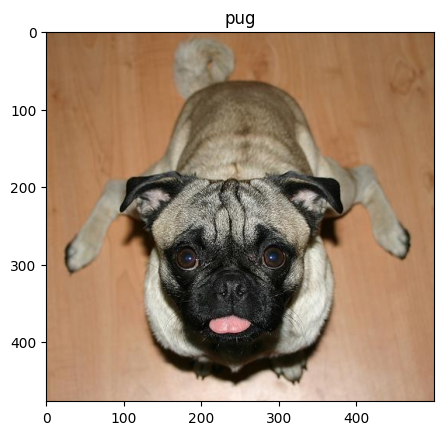

In [28]:
random_number = randint(0, len(data))
plt.imshow(plt.imread(data.samples[random_number][0]))
plt.title(list_of_classes[data.samples[random_number][1]])

In [10]:
# Using pretrained weights:
weights=ResNet50_Weights.IMAGENET1K_V2
resnet50(weights=weights)
transformations = weights.transforms()
transformations

ImageClassification(
    crop_size=[224]
    resize_size=[232]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [67]:
# We will splitting by 80% for training, 10% for validation and 10% for testing

BATCH_SIZE = 1
train, val, test = torch.utils.data.random_split(data, [0.8, 0.1, 0.1])

data_loader = {}
data_loader["train"] = DataLoader(train, batch_size=BATCH_SIZE, shuffle=True)
data_loader["val"] = DataLoader(train, batch_size=BATCH_SIZE, shuffle=True)
data_loader["test"] = DataLoader(train, batch_size=BATCH_SIZE, shuffle=True)


In [12]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [13]:
for param in model.parameters():
    print(param.requires_grad)

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


In [14]:
for param in model.parameters():
    param.requires_grad = False

In [15]:
print("Current FC layer:", model.fc)
model.fc = nn.Linear(model.fc.in_features, len(list_of_classes))
print("Model with new FC layer:", model.fc)

Current FC layer: Linear(in_features=2048, out_features=1000, bias=True)
Model with new FC layer: Linear(in_features=2048, out_features=120, bias=True)


In [16]:
for param in model.parameters():
    print(param.requires_grad)

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
True


In [24]:

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [73]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in data_loader[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [76]:

model_conv = train_model(model, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=1)

Epoch 0/0
----------


KeyboardInterrupt: 

In [77]:

# !pip freeze > requirements.txt


# traindataset = MyLazyDataset(train,aug)
# valdataset = MyLazyDataset(val,aug)
# testdataset = MyLazyDataset(test,aug)
# num_workers=2
# batch_size=6
# trainLoader = DataLoader(traindataset , batch_size=batch_size, 
#                                            num_workers=num_workers,  shuffle=True)
# valLoader = DataLoader(valdataset, batch_size=batch_size, 
#                                           num_workers=num_workers )
# testLoader = DataLoader(testdataset, batch_size=batch_size, 
#                                           num_workers=num_workers)
